In [1]:
# To derive the mean trajectory and the impulse models, we will use object tracking to obtain the "raw" trajectory first.

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import cv2

In [2]:
init_frame_id = 0
# Load the first label file for the first frame
detectionLabel = np.loadtxt('labels/frame{}.txt'.format(init_frame_id), delimiter=',') # x1, y1, x2, y2

In [3]:
# Load the first frame of the video
frame = cv2.imread('frames/frame{}.jpg'.format(init_frame_id))

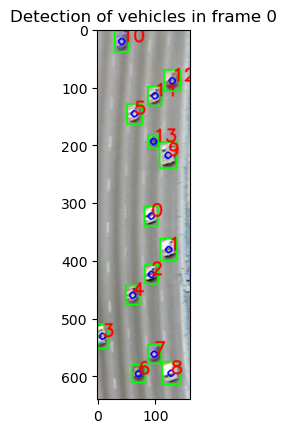

In [4]:
detections = []
# Circle the detected objects
for i in range(detectionLabel.shape[0]):
    cv2.rectangle(frame, (int(detectionLabel[i,0]), int(detectionLabel[i,1])), (int(detectionLabel[i,2]), int(detectionLabel[i,3])), (0, 255, 0), 2)
    center = (int((detectionLabel[i,0]+detectionLabel[i,2])/2), int((detectionLabel[i,1]+detectionLabel[i,3])/2))
    detections.append(center)
    cv2.circle(frame, center, 5, (0, 0, 255), 2)
    cv2.putText(frame, str(i), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

# Convert the detections to numpy array
detections = np.array(detections)

# Show the first frame with detected objects
plt.imshow(frame)
plt.title('Detection of vehicles in frame {}'.format(init_frame_id))
plt.show()

In [6]:
# ids_to_track are vehicles starting at the bottom of the image (y > 550)
ids_to_track = np.where(detections[:,1] > 550)[0]
print('ids_to_track: {}'.format(ids_to_track))

ids_to_track: [6 7 8]


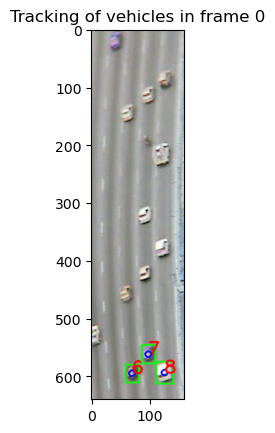

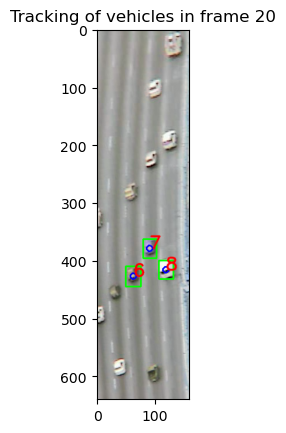

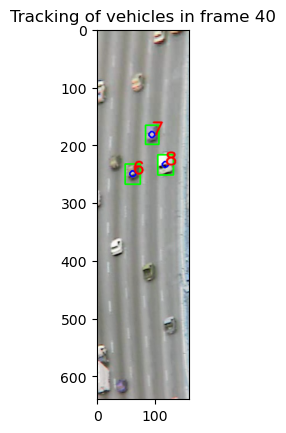

Tracking failed for object 7 at frame 59.


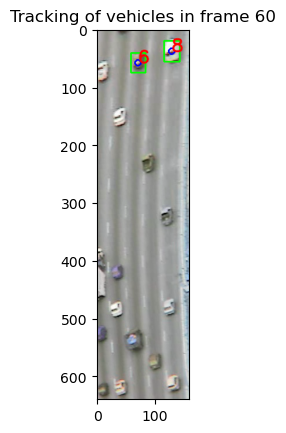

Tracking failed for object 8 at frame 67.
Tracking failed for object 6 at frame 68.


In [7]:
max_frames = 75

x_vec = np.zeros((len(ids_to_track), max_frames))
y_vec = np.zeros((len(ids_to_track), max_frames))

# Initialize the tracker
trackers = []
failed_trackers = []

for id in ids_to_track:
    tracker = cv2.TrackerCSRT_create()
    bbox = (detectionLabel[id,0], detectionLabel[id,1], detectionLabel[id,2]-detectionLabel[id,0], detectionLabel[id,3]-detectionLabel[id,1])
    # convert bbox to int
    bbox = [int(v) for v in bbox]
    tracker.init(frame, bbox)
    trackers.append(tracker)

# Start tracking
for frame_id in range(init_frame_id, max_frames):
    frame = cv2.imread('frames/frame{}.jpg'.format(frame_id))
    for i, tracker in enumerate(trackers):
        success, box = tracker.update(frame)
        if success:
            (x, y, w, h) = [int(v) for v in box]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            center = (int(x+w/2), int(y+h/2))
            # Append the center to the trajectory
            x_vec[i, frame_id] = center[0]
            y_vec[i, frame_id] = center[1]
            cv2.circle(frame, center, 5, (0, 0, 255), 2)
            cv2.putText(frame, str(ids_to_track[i]), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        else:
            # print('Tracking failed for object {}'.format(ids_to_track[i]))
            if i not in failed_trackers:
                failed_trackers.append(i)
                print('Tracking failed for object {} at frame {}.'.format(ids_to_track[i], frame_id))
    # Remove the failed trackers
    # trackers = [tracker for i, tracker in enumerate(trackers) if i not in failed_trackers]
    if frame_id % 20 == 0: # change to false 
        plt.imshow(frame)
        plt.title('Tracking of vehicles in frame {}'.format(frame_id))
        plt.show()
    frame_old = frame.copy()


Text(0.5, 1.0, 'Trajectories of objects')

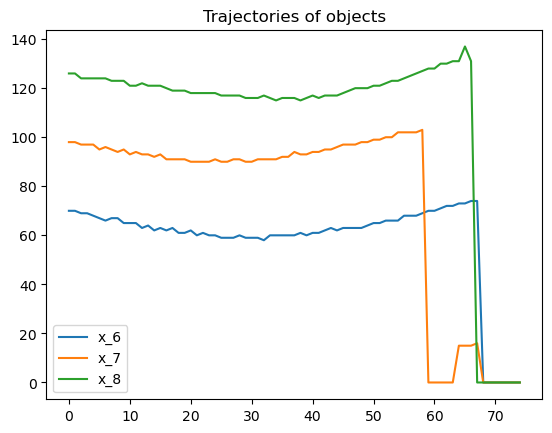

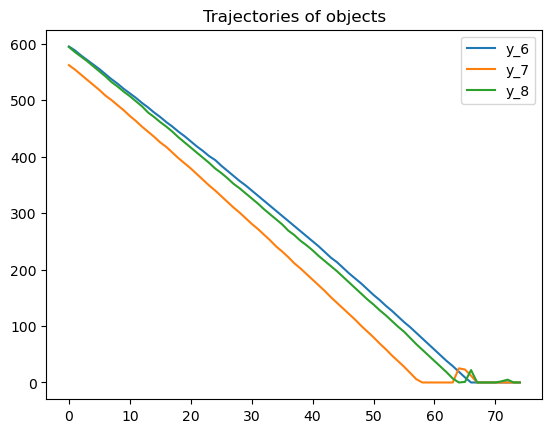

In [8]:
# Plot the trajectories
plt.figure()
for i in range(len(ids_to_track)):
    plt.plot(np.arange(max_frames), x_vec[i,:], label='x_{}'.format(ids_to_track[i]))
plt.legend()
plt.title('Trajectories of objects')

plt.figure()
for i in range(len(ids_to_track)):
    plt.plot(np.arange(max_frames), y_vec[i,:], label='y_{}'.format(ids_to_track[i]))
plt.legend()
plt.title('Trajectories of objects')


Text(0.5, 1.0, 'Derivatives of trajectories of objects')

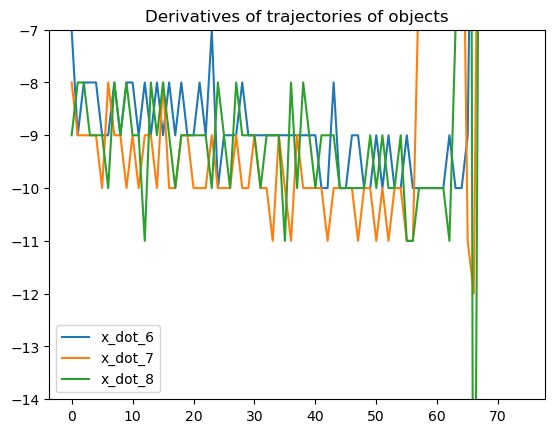

In [9]:
# Derivative of the trajectories
x_dot_vec = np.zeros((len(ids_to_track), max_frames))
y_dot_vec = np.zeros((len(ids_to_track), max_frames))

for i in range(len(ids_to_track)):
    for j in range(max_frames-1):
        x_dot_vec[i,j] = x_vec[i,j+1] - x_vec[i,j]
        y_dot_vec[i,j] = y_vec[i,j+1] - y_vec[i,j]

plt.figure()
for i in range(len(ids_to_track)):
    plt.plot(np.arange(max_frames), y_dot_vec[i,:], label='x_dot_{}'.format(ids_to_track[i]))
plt.legend()
plt.ylim((-14, -7))
plt.title('Derivatives of trajectories of objects')


In [ ]:
# Save the trajectories to npy files
